In [1]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='sEAyMxuHCrLcPRc8A0Via6cfXdTGC50C2jKMCv44zgJP',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.eu-gb.cloud-object-storage.appdomain.cloud')

bucket = 'nsapproject-donotdelete-pr-gl1yi3k7wtophv'
object_key = 'new-nsapac.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_1 = pd.read_csv(body)
df_1.head(10)


,state_ut_name,state_ut_code,constituency,constituency_code,fiscal_year,indicator_1,indicator_2,indicator_3
0,Bihar,4,Valmiki Nagar,1,2019-20,10.12,10.12,100.0
1,Bihar,4,Ramnagar (SC),2,2019-20,7.19,7.19,100.0
2,Bihar,4,Narkatiaganj,3,2019-20,7.17,7.17,100.0
3,Bihar,4,Bagaha,4,2019-20,6.46,6.46,100.0
4,Bihar,4,Lauriya,5,2019-20,7.39,7.39,100.0
5,Bihar,4,Nautan,6,2019-20,8.54,8.54,100.0
6,Bihar,4,Chanpatia,7,2019-20,9.76,9.76,100.0
7,Bihar,4,Bettiah,8,2019-20,6.67,6.67,100.0
8,Bihar,4,Sikta,9,2019-20,8.41,8.41,100.0
9,Bihar,4,Raxaul,10,2019-20,7.63,7.63,100.0


In [3]:
df = df_1.copy()

In [4]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.head()

,state_ut_name,state_ut_code,constituency,constituency_code,fiscal_year,indicator_1,indicator_2,indicator_3
0,Bihar,4,Valmiki Nagar,1,2019-20,10.12,10.12,100.0
1,Bihar,4,Ramnagar (SC),2,2019-20,7.19,7.19,100.0
2,Bihar,4,Narkatiaganj,3,2019-20,7.17,7.17,100.0
3,Bihar,4,Bagaha,4,2019-20,6.46,6.46,100.0
4,Bihar,4,Lauriya,5,2019-20,7.39,7.39,100.0


In [5]:
# Check data types and missing/null values
print("Column info:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())


Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2504 entries, 0 to 2503
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state_ut_name      2504 non-null   object 
 1   state_ut_code      2504 non-null   int64  
 2   constituency       2504 non-null   object 
 3   constituency_code  2504 non-null   int64  
 4   fiscal_year        2504 non-null   object 
 5   indicator_1        2006 non-null   float64
 6   indicator_2        2006 non-null   float64
 7   indicator_3        2006 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 156.6+ KB

Missing values:
state_ut_name          0
state_ut_code          0
constituency           0
constituency_code      0
fiscal_year            0
indicator_1          498
indicator_2          498
indicator_3          498
dtype: int64


In [6]:
from sklearn.preprocessing import LabelEncoder

# 🔹 Step 3.1: Create a new target column (based on which indicator has the highest value)
df['nsap_scheme'] = df[['indicator_1', 'indicator_2', 'indicator_3']].idxmax(axis=1)

# 🔹 Step 3.2: Encode the new target column
le = LabelEncoder()
df['nsap_scheme'] = le.fit_transform(df['nsap_scheme'])

# 🔹 Optional: Show the mapping for interpretability
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping (scheme name → encoded value):")
print(label_map)

# 🔹 Show a preview
df[['indicator_1', 'indicator_2', 'indicator_3', 'nsap_scheme']].head()

Label Mapping (scheme name → encoded value):
{'indicator_1': 0, 'indicator_3': 1, nan: 2}


/tmp/wsuser/ipykernel_136/3105142371.py:4: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df['nsap_scheme'] = df[['indicator_1', 'indicator_2', 'indicator_3']].idxmax(axis=1)


,indicator_1,indicator_2,indicator_3,nsap_scheme
0,10.12,10.12,100.0,1
1,7.19,7.19,100.0,1
2,7.17,7.17,100.0,1
3,6.46,6.46,100.0,1
4,7.39,7.39,100.0,1


In [7]:
print(df.columns.tolist())

['state_ut_name', 'state_ut_code', 'constituency', 'constituency_code', 'fiscal_year', 'indicator_1', 'indicator_2', 'indicator_3', 'nsap_scheme']


In [9]:
from sklearn.model_selection import train_test_split

# 🔹 Define features (X) and target (y)
X = df[['indicator_1', 'indicator_2', 'indicator_3']]  # Feature columns
y = df['nsap_scheme']                                 # Target column

# 🔹 Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)  # stratify keeps class distribution balanced

# 🔹 Print result shapes
print("Train-test split complete!")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Train-test split complete!
X_train shape: (2003, 3)
X_test shape: (501, 3)
y_train shape: (2003,)
y_test shape: (501,)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import numpy as np

# 🔹 Step 5.0: Handle NaN values (impute with mean)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# 🔹 Step 5.1: Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_imputed, y_train)

# 🔹 Step 5.2: Predict on test data
y_pred = model.predict(X_test_imputed)

# 🔹 Step 5.3: Evaluate the model
print("✅ Accuracy Score:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Accuracy Score: 1.0

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00       397
           2       1.00      1.00      1.00       100

    accuracy                           1.00       501
   macro avg       1.00      1.00      1.00       501
weighted avg       1.00      1.00      1.00       501


🧩 Confusion Matrix:
 [[  4   0   0]
 [  0 397   0]
 [  0   0 100]]


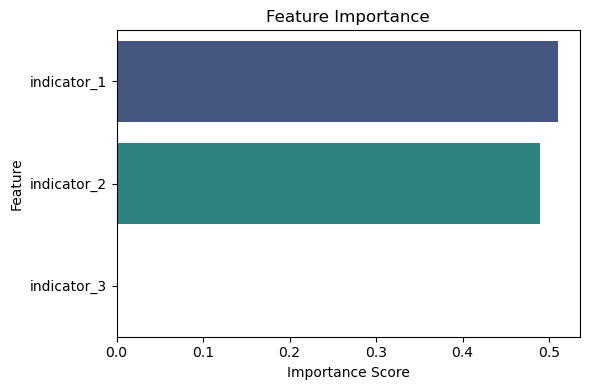

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Plot without emoji to avoid warning
plt.figure(figsize=(6, 4))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [13]:
probs = model.predict_proba(X_test_imputed)
confidence = probs.max(axis=1)

# Show prediction + confidence
for i in range(5):
    print(f"Predicted Scheme: {y_pred[i]}, Confidence: {confidence[i]:.2f}")

Predicted Scheme: 2, Confidence: 1.00
Predicted Scheme: 1, Confidence: 1.00
Predicted Scheme: 1, Confidence: 1.00
Predicted Scheme: 2, Confidence: 1.00
Predicted Scheme: 2, Confidence: 1.00


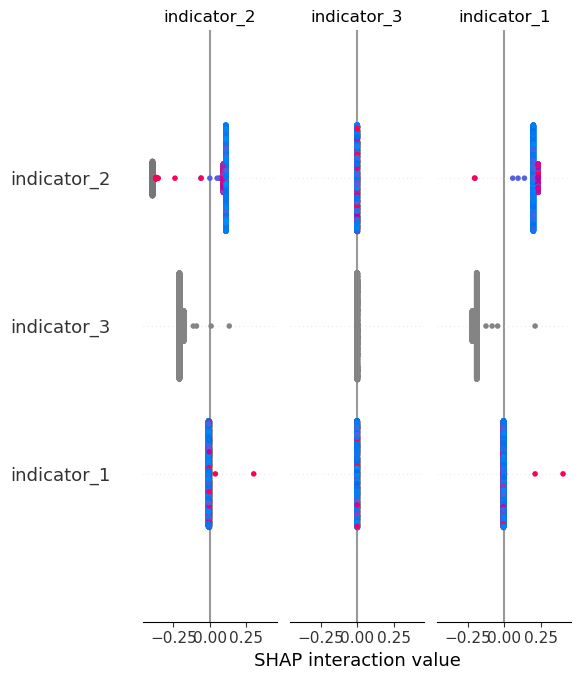

In [16]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_imputed)

shap.summary_plot(shap_values, X_train, feature_names=X.columns)

In [18]:
region_scores = df.groupby('state_ut_name')[['indicator_1', 'indicator_2', 'indicator_3']].mean()
lowest_states = region_scores.mean(axis=1).sort_values().head(5)
print("States with weakest scheme coverage:")
print(lowest_states)

States with weakest scheme coverage:
state_ut_name
Maharashtra      35.494916
Uttar Pradesh    37.096382
Chhattisgarh     39.035918
Bihar            39.520972
Odisha           56.689555
dtype: float64


In [19]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier  # You need to pip install xgboost if not installed
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the models
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # Prevents warning
}

# Train, predict, evaluate
for name, model in models.items():
    model.fit(X_train_imputed, y_train)
    preds = model.predict(X_test_imputed)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}")

RandomForest Accuracy: 1.0000
LogisticRegression Accuracy: 0.8004
XGBoost Accuracy: 0.8543
